In [1]:
import requests
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

In [2]:
API_URL = 'https://www.deribit.com/api/v2/'
CURRENCY = 'BTC'
EXPIRATION_DATES = ['30AUG24', '6SEP24', '27SEP24', '25OCT24', '8NOV24', '27DEC24']  
RISK_FREE_RATE = 0.01  

In [3]:
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def black_scholes_put(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)


In [4]:
def implied_volatility(S, K, T, r, option_price, option_type='call'):
    if option_type == 'call':
        objective = lambda sigma: black_scholes_call(S, K, T, r, sigma) - option_price
    else:
        objective = lambda sigma: black_scholes_put(S, K, T, r, sigma) - option_price
    
    try:
        lower_bound = 1e-6
        upper_bound = 2.0 if option_type == 'call' else 4.0
        implied_vol = brentq(objective, lower_bound, upper_bound, xtol=1e-6)
        return implied_vol
    except ValueError:
        print(f"Failed to compute implied volatility for strike price {K}")
        return np.nan  

In [5]:
def fetch_instruments(currency, expiration_dates):
    endpoint = f'{API_URL}public/get_instruments'
    params = {'currency': currency, 'kind': 'option', 'expired': 'false'}
    response = requests.get(endpoint, params=params)
    instruments = response.json()['result']
    return [inst for inst in instruments if any(expiration in inst['instrument_name'] for expiration in expiration_dates)]

In [6]:
def calculate_time_to_expiration(instrument_name):
    print('instrument_name:', instrument_name)  
    expiration_str = instrument_name.split('-')[1]  
    expiration_date = datetime.strptime(expiration_str, '%d%b%y')  
    current_date = datetime.now()
    days_until_expiration = (expiration_date - current_date).days  
    return days_until_expiration / 365.0  

In [32]:
def fetch_ticker_data(instrument_name):
    endpoint = f'{API_URL}public/ticker'
    params = {'instrument_name': instrument_name}
    response = requests.get(endpoint, params=params)
    print(response.json()['result'])
    return response.json()['result']

In [8]:
def fetch_spot_price(currency):
    endpoint = f'{API_URL}public/get_index_price'
    params = {'index_name': 'btc_usd'}
    response = requests.get(endpoint, params=params)
    return response.json()['result']['index_price']

In [9]:
instruments = fetch_instruments(CURRENCY, EXPIRATION_DATES)
spot_price = fetch_spot_price(CURRENCY)

# return np.array(strikes), np.array(expirations), np.array(implied_vols)

In [10]:
print(len(instruments))

572


In [11]:
strikes = []
expirations = []
option_types = []
implied_vols = []

for instrument in instruments:
    option_type = 'call' if 'C' == instrument['instrument_name'][-1] else 'put'
    print(option_type)
    K = instrument['strike']
    T = calculate_time_to_expiration(instrument['instrument_name'])  # Calculate T based on the instrument name
    
    ticker = fetch_ticker_data(instrument['instrument_name'])
    print(ticker)
    option_price = (ticker['best_bid_price'] + ticker['best_ask_price']) / 2
    
    iv = implied_volatility(spot_price, K, T, RISK_FREE_RATE, option_price, option_type)
    
    strikes.append(K)
    expirations.append(T)
    option_types.append(option_type)
    implied_vols.append(iv)

call
instrument_name: BTC-30AUG24-30000-C
{'estimated_delivery_price': 59776.78, 'best_bid_amount': 70.0, 'best_ask_amount': 5.2, 'underlying_index': 'BTC-30AUG24', 'ask_iv': 167.87, 'bid_iv': 0.0, 'underlying_price': 59964.72, 'mark_iv': 127.02, 'interest_rate': 0.0, 'best_bid_price': 0.4985, 'best_ask_price': 0.501, 'mark_price': 0.4997, 'open_interest': 38.3, 'max_price': 0.522, 'min_price': 0.479, 'settlement_price': 0.48852184, 'last_price': 0.488, 'instrument_name': 'BTC-30AUG24-30000-C', 'index_price': 59776.78, 'greeks': {'rho': 11.07067, 'theta': -2.74097, 'vega': 0.58328, 'gamma': 0.0, 'delta': 0.99844}, 'stats': {'volume_usd': 125566.5, 'volume': 4.4, 'price_change': 0.0, 'low': 0.488, 'high': 0.488}, 'state': 'open', 'timestamp': 1723837160870}
Failed to compute implied volatility for strike price 30000.0
put
instrument_name: BTC-30AUG24-30000-P
{'estimated_delivery_price': 59809.95, 'best_bid_amount': 51.7, 'best_ask_amount': 0.1, 'underlying_index': 'BTC-30AUG24', 'ask_iv

In [12]:
print(implied_vols)
print(option_types)

[nan, 0.7242337556211886, nan, 0.5694003851901116, nan, 0.438944330107229, nan, 0.39325911956104687, nan, 0.3469233368544511, nan, 0.3247030410105906, nan, 0.30232251143813543, nan, 0.2806348061134138, nan, 0.25953968939138555, nan, 0.2380088497651912, nan, 0.21672953516266108, nan, 0.19549617913389733, nan, 0.17478989828499347, nan, 0.15351799215922762, nan, 0.13242635816352366, nan, 0.11099780620898607, nan, 0.08932156143581108, nan, 0.06711644487276396, nan, 0.044161156952592574, nan, 0.020059423071786903, 0.007879660126371412, nan, 0.03257268152585397, nan, 0.05480287405249204, nan, 0.07550803308185132, nan, 0.09515700511465677, nan, 0.11348044511396188, nan, 0.1309550478900176, nan, 0.14773959322907218, nan, 0.16390158531759633, nan, 0.1792256506570042, nan, 0.19396669563076901, nan, 0.20840588242974262, nan, 0.22259587432832234, nan, 0.2359002802450817, nan, 0.24840017461755567, nan, 0.2621006220299034, nan, 0.2743915114803402, nan, 0.28752078842407763, nan, 0.2995920195433404, n

In [13]:
def interpolate_implied_volatility(strikes, expirations, option_types, implied_vols):
    """
    Interpolate missing (np.nan) values of implied volatility.
    """
    data = {'Strike': strikes, 'Expiration': expirations, 'OptionType': option_types, 'ImpliedVolatility': implied_vols}
    df = pd.DataFrame(data)

    df.set_index(['Expiration', 'OptionType', 'Strike'], inplace=True)
    df.sort_index(inplace=True)

    unstacked = df['ImpliedVolatility'].unstack(level=[0, 1])  # Unstack by Expiration and OptionType
    unstacked_interp = unstacked.interpolate(method='linear').ffill().bfill()

    interpolated_df = unstacked_interp.stack(level=[0, 1]).reset_index(name='ImpliedVolatility')

    return interpolated_df



In [14]:
interpolated_df = interpolate_implied_volatility(strikes, expirations, option_types, implied_vols)

remaining_nans = interpolated_df[interpolated_df['ImpliedVolatility'].isna()]
print(f"Remaining NaN values:\n{remaining_nans}")

Remaining NaN values:
Empty DataFrame
Columns: [Strike, Expiration, OptionType, ImpliedVolatility]
Index: []


In [15]:
print(interpolated_df)
print(interpolated_df['Expiration'].unique())

        Strike  Expiration OptionType  ImpliedVolatility
0      10000.0    0.035616       call           0.007880
1      10000.0    0.035616        put           0.724234
2      10000.0    0.054795       call           0.006224
3      10000.0    0.054795        put           0.250719
4      10000.0    0.112329       call           0.003962
...        ...         ...        ...                ...
1063  300000.0    0.189041        put           0.010418
1064  300000.0    0.227397       call           0.373834
1065  300000.0    0.227397        put           0.049880
1066  300000.0    0.361644       call           0.530664
1067  300000.0    0.361644        put           0.008703

[1068 rows x 4 columns]
[0.03561644 0.05479452 0.11232877 0.1890411  0.22739726 0.36164384]


In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [17]:
calls_df = interpolated_df[interpolated_df['OptionType'] == 'call']
puts_df = interpolated_df[interpolated_df['OptionType'] == 'put']

calls_pivot = calls_df.pivot(index='Strike', columns='Expiration', values='ImpliedVolatility')
puts_pivot = puts_df.pivot(index='Strike', columns='Expiration', values='ImpliedVolatility')

In [18]:
print(calls_pivot)
print(len(calls_pivot[expirations]))

Expiration  0.035616  0.054795  0.112329  0.189041  0.227397  0.361644
Strike                                                                
10000.0     0.007880  0.006224  0.003962  0.002550  0.002090  0.000872
15000.0     0.007880  0.006224  0.003962  0.002550  0.002090  0.000872
18000.0     0.007880  0.006224  0.003962  0.002550  0.002090  0.000872
19000.0     0.007880  0.006224  0.003962  0.002550  0.002090  0.000872
20000.0     0.007880  0.006224  0.003962  0.002550  0.002090  0.000872
...              ...       ...       ...       ...       ...       ...
160000.0    0.679463  0.306910  0.559652  0.320243  0.373834  0.350041
180000.0    0.679463  0.306910  0.612972  0.320243  0.373834  0.384926
200000.0    0.679463  0.306910  0.660190  0.320243  0.373834  0.415790
240000.0    0.679463  0.306910  0.754559  0.320243  0.373834  0.468396
300000.0    0.679463  0.306910  0.754559  0.320243  0.373834  0.530664

[89 rows x 6 columns]
89


Call Options - Z min: 0.0008717432183347987 Z max: 0.7545591050368438


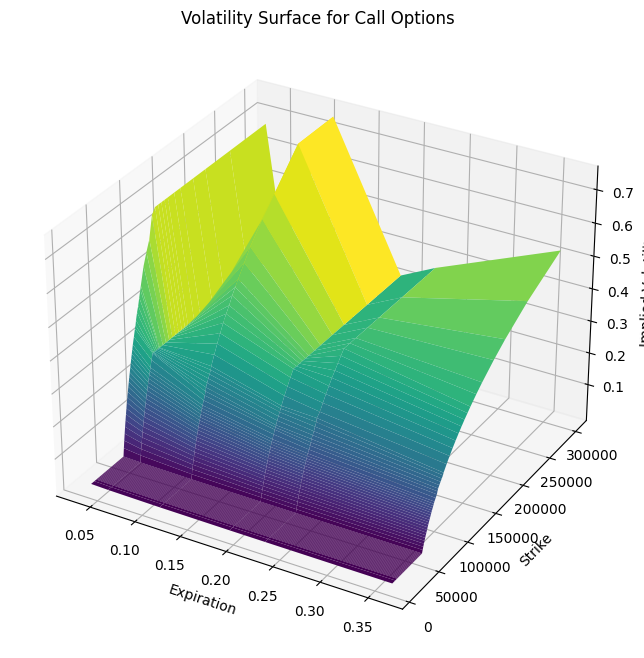

In [19]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(calls_pivot.columns, calls_pivot.index)
Z = np.array(calls_pivot)

print("Call Options - Z min:", Z.min(), "Z max:", Z.max())

ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', rstride=1, cstride=1)

ax.set_xlabel('Expiration')
ax.set_ylabel('Strike')
ax.set_zlabel('Implied Volatility')
ax.set_title('Volatility Surface for Call Options')

plt.show()

Call Options - Z min: 0.008703108874965304 Z max: 1.0443214411476356


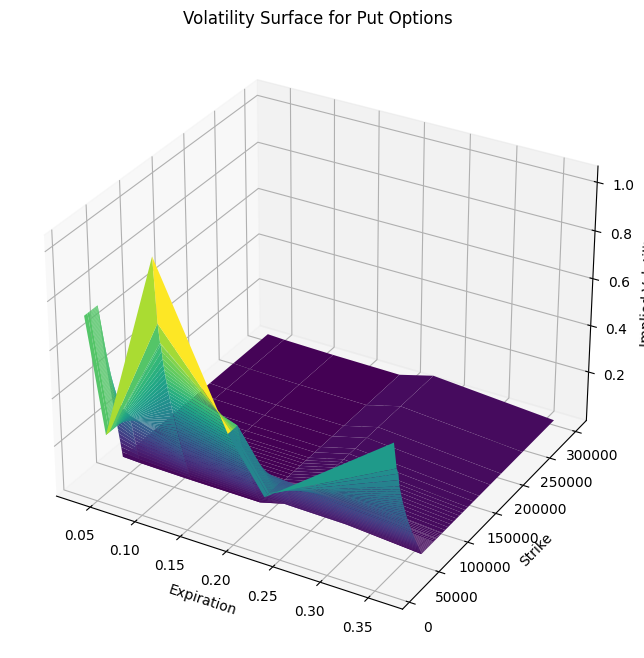

In [20]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(puts_pivot.columns, puts_pivot.index)
Z = np.array(puts_pivot)

print("Call Options - Z min:", Z.min(), "Z max:", Z.max())

ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', rstride=1, cstride=1)

ax.set_xlabel('Expiration')
ax.set_ylabel('Strike')
ax.set_zlabel('Implied Volatility')
ax.set_title('Volatility Surface for Put Options')

plt.show()

In [21]:
from datetime import datetime


In [39]:
# Lists to store data for plotting
strikes = []
expirations = []
ask_ivs = []
bid_ivs = []
option_types = []
tickerdata = []

# Extract the relevant data from the instruments
for instrument in instruments:
    strike_price = int(instrument['instrument_name'].split('-')[-2])  # Extract strike price
    expiration_str = instrument['instrument_name'].split('-')[1]  # Extract expiration date string (e.g., '27SEP24')
    expiration_date = datetime.strptime(expiration_str, '%d%b%y')  # Convert to datetime object
    time_to_expiration = calculate_time_to_expiration(instrument['instrument_name'])  # Time to expiration in years
    option_type = 'call' if 'C' == instrument['instrument_name'][-1] else 'put'  # Determine if it's a call or put
    ticker = fetch_ticker_data(instrument['instrument_name'])
    tickerdata.append(ticker)

    strikes.append(strike_price)
    expirations.append(time_to_expiration)
    ask_ivs.append(ticker['ask_iv'])
    bid_ivs.append(ticker['bid_iv'])
    option_types.append(option_type)

In [45]:
print(bid_ivs)
print(ask_ivs)
print(option_types)
print(strikes)
print(expirations)

[0.0, 124.11, 0.0, 104.81, 0.0, 87.08, 0.0, 81.62, 0.0, 77.48, 0.0, 74.58, 0.0, 71.34, 0.0, 68.58, 0.0, 66.02, 50.74, 63.48, 52.41, 61.27, 51.67, 59.47, 51.7, 57.41, 54.31, 55.29, 51.05, 53.43, 50.01, 52.45, 50.99, 51.84, 50.3, 50.57, 49.51, 50.03, 49.23, 49.33, 49.36, 49.07, 49.27, 48.6, 49.71, 47.86, 49.47, 47.76, 50.17, 47.75, 50.5, 45.03, 50.59, 44.25, 51.77, 44.9, 52.59, 43.77, 53.84, 37.75, 54.76, 0.0, 55.75, 0.0, 56.59, 0.0, 58.01, 0.0, 59.71, 0.0, 60.28, 0.0, 61.22, 0.0, 62.82, 0.0, 64.23, 0.0, 65.38, 0.0, 66.24, 0.0, 69.02, 0.0, 71.05, 0.0, 70.02, 0.0, 72.01, 0.0, 75.94, 0.0, 79.78, 0.0, 78.13, 0.0, 81.55, 0.0, 83.24, 0.0, 91.33, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.1, 65.58, 53.33, 61.66, 52.51, 58.0, 50.57, 54.48, 49.81, 53.61, 48.99, 52.69, 48.6, 51.59, 48.51, 50.91, 48.56, 50.46, 49.21, 50.13, 49.35, 49.81, 49.44, 49.1, 49.61, 48.36, 49.32, 48.32, 49.75, 47.18, 49.9, 46.75, 50.19, 46.88, 51.94, 44.58, 53.22, 44.48, 54.85, 36.93, 56.84, 0.0, 58.58, 0.0, 60.49, 0.

In [46]:
# Convert lists to numpy arrays for ease of indexing
bid_ivs = np.array(bid_ivs)
ask_ivs = np.array(ask_ivs)
strikes = np.array(strikes)
expirations = np.array(expirations)
option_types = np.array(option_types)

# Separate calls and puts
call_mask = option_types == 'call'
put_mask = option_types == 'put'

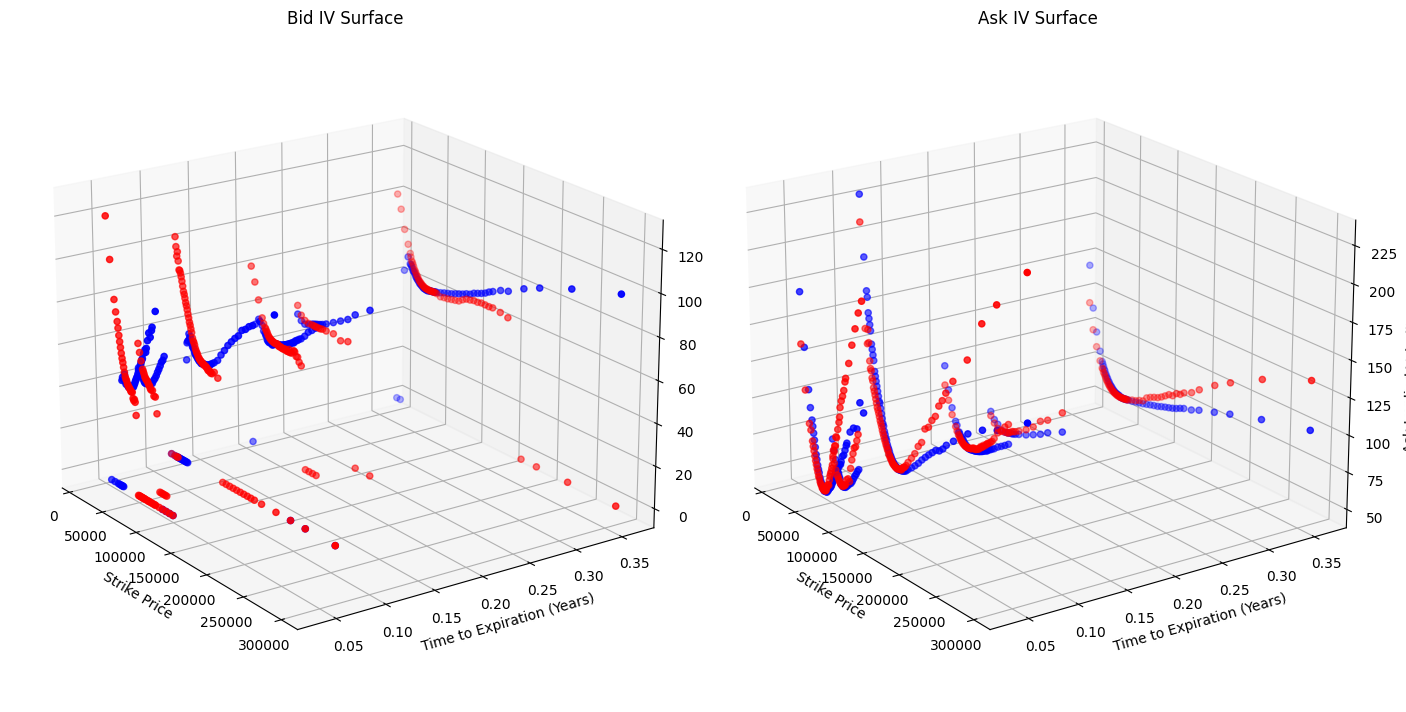

In [48]:
# Create 3D plots
fig = plt.figure(figsize=(14, 7))

# Bid IV Surface
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(strikes[call_mask], expirations[call_mask], bid_ivs[call_mask], c='blue', label='Call Bid IV')
ax1.scatter(strikes[put_mask], expirations[put_mask], bid_ivs[put_mask], c='red', label='Put Bid IV')
ax1.set_xlabel('Strike Price')
ax1.set_ylabel('Time to Expiration (Years)')
ax1.set_zlabel('Bid Implied Volatility')
ax1.set_title('Bid IV Surface')
ax1.view_init(elev=20., azim=-35)  # Adjust view angle if necessary

# Ask IV Surface
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(strikes[call_mask], expirations[call_mask], ask_ivs[call_mask], c='blue', label='Call Ask IV')
ax2.scatter(strikes[put_mask], expirations[put_mask], ask_ivs[put_mask], c='red', label='Put Ask IV')
ax2.set_xlabel('Strike Price')
ax2.set_ylabel('Time to Expiration (Years)')
ax2.set_zlabel('Ask Implied Volatility')
ax2.set_title('Ask IV Surface')
ax2.view_init(elev=20., azim=-35)  # Adjust view angle if necessary

plt.tight_layout()
plt.show()

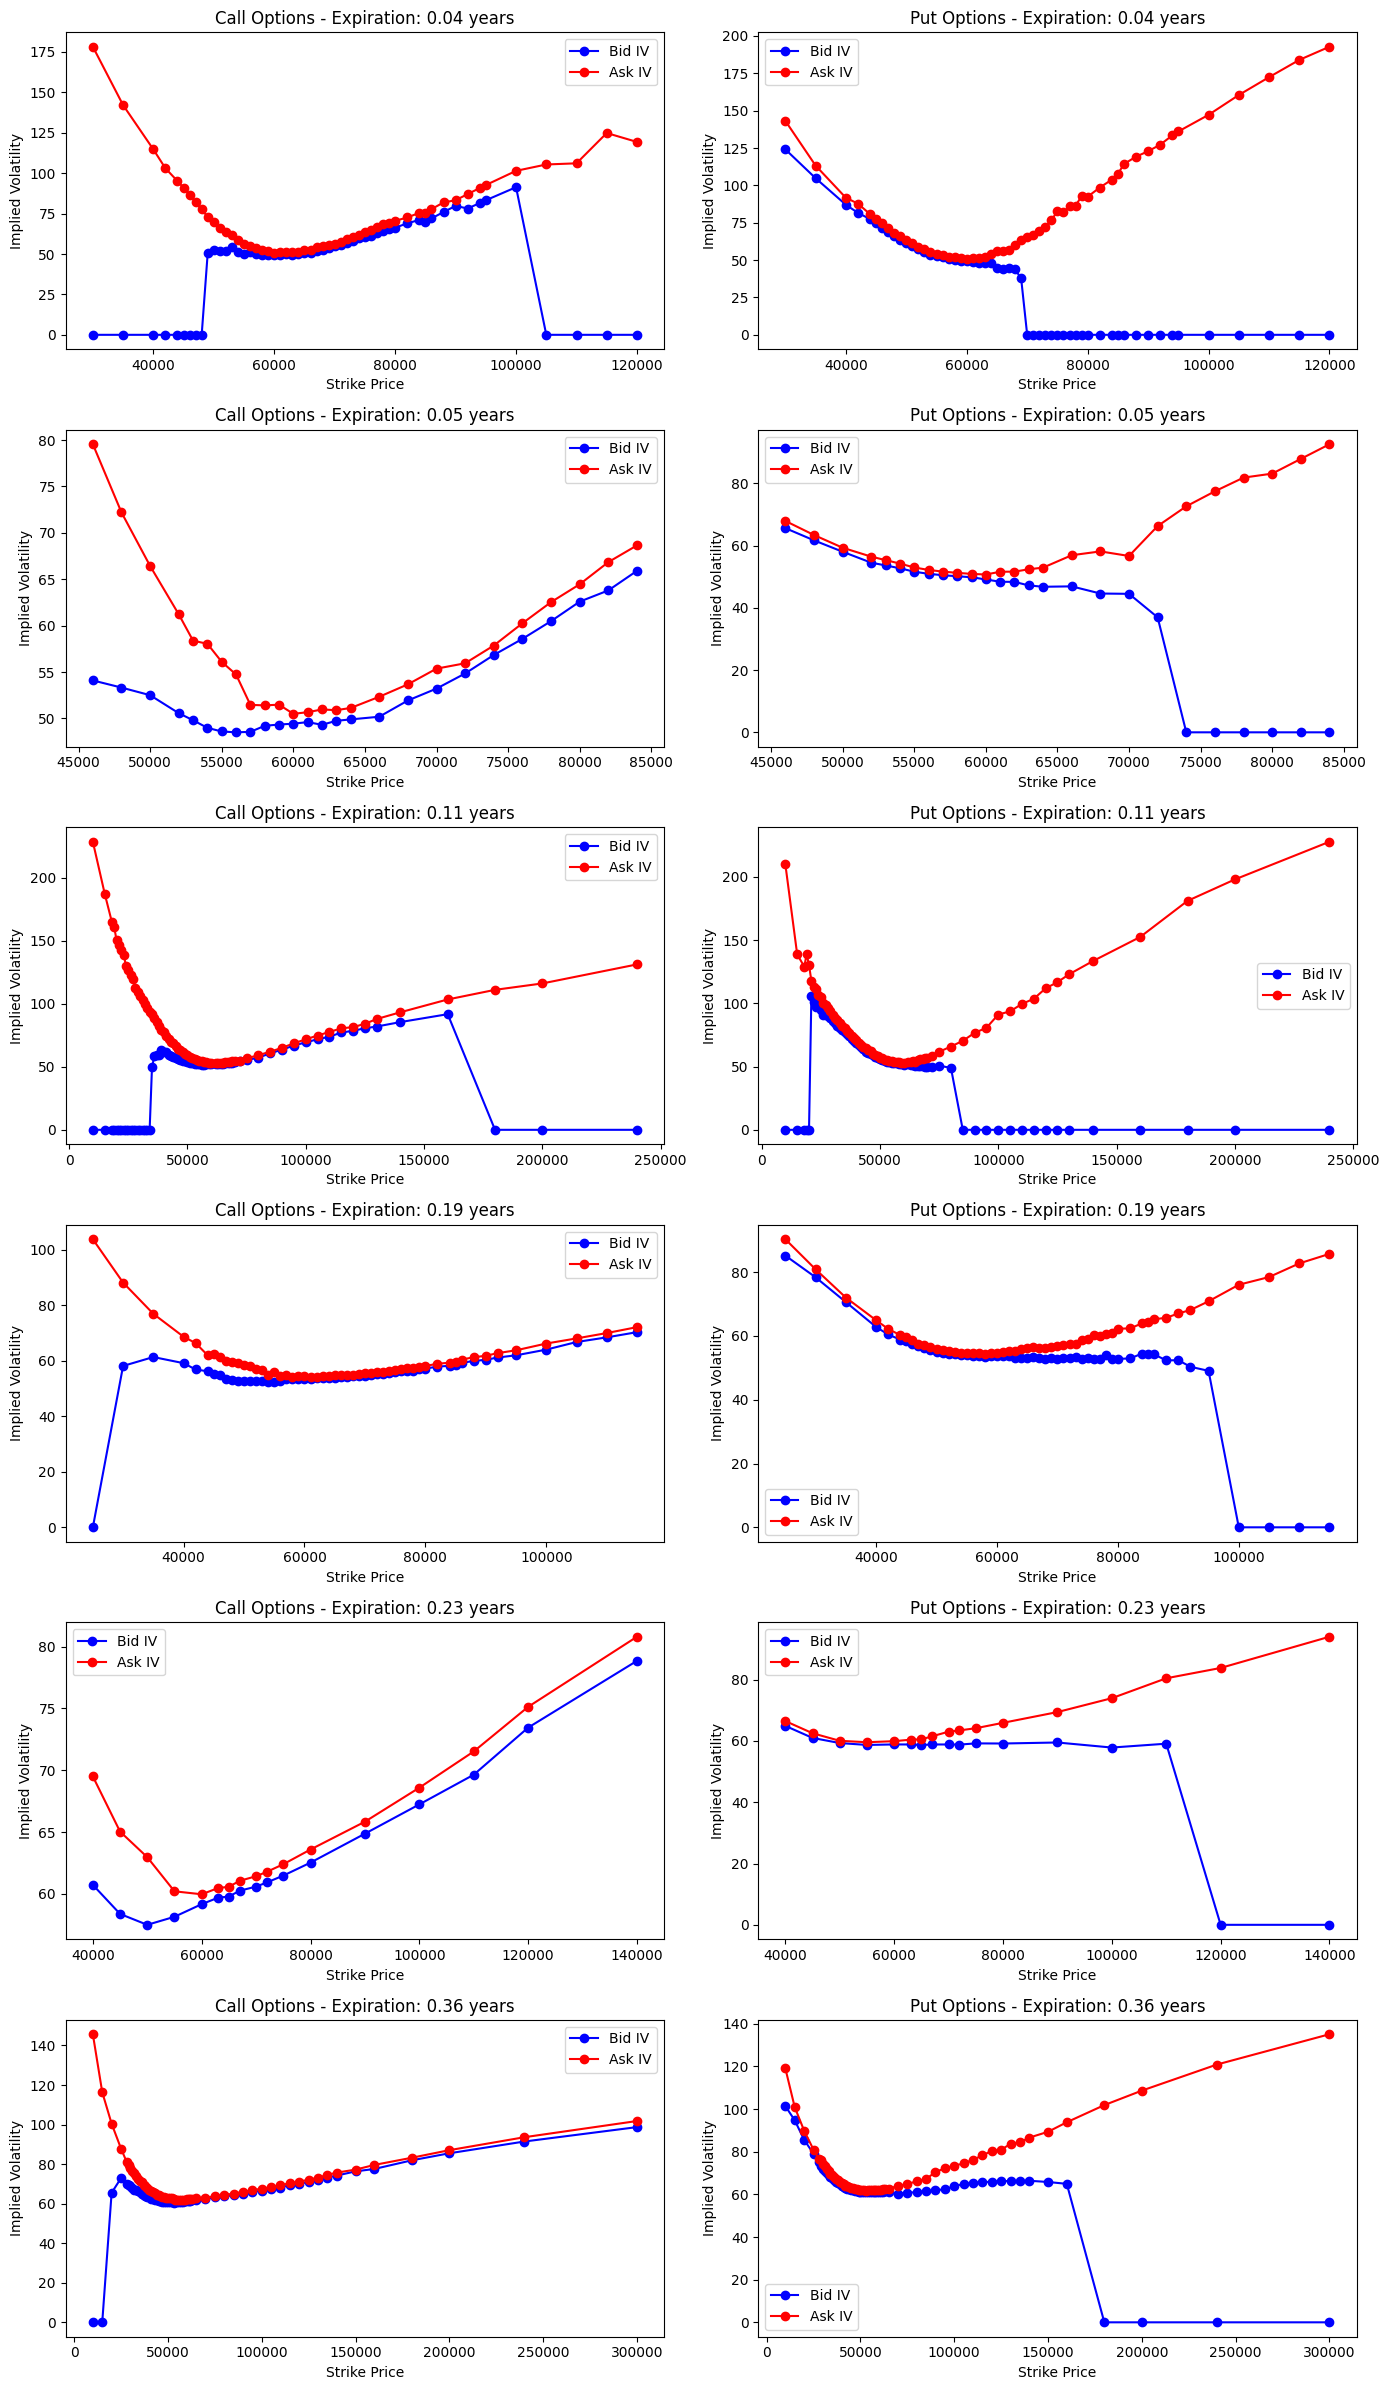

In [49]:
# Get unique expiration dates
unique_expirations = np.unique(expirations)

# Create cross-sectional 2D plots
fig, axes = plt.subplots(len(unique_expirations), 2, figsize=(14, len(unique_expirations) * 4))

for i, expiration in enumerate(unique_expirations):
    mask = expirations == expiration
    
    # Plot for Call options
    axes[i, 0].plot(strikes[mask & (option_types == 'call')], bid_ivs[mask & (option_types == 'call')], 'bo-', label='Bid IV')
    axes[i, 0].plot(strikes[mask & (option_types == 'call')], ask_ivs[mask & (option_types == 'call')], 'ro-', label='Ask IV')
    axes[i, 0].set_title(f'Call Options - Expiration: {expiration:.2f} years')
    axes[i, 0].set_xlabel('Strike Price')
    axes[i, 0].set_ylabel('Implied Volatility')
    axes[i, 0].legend()

    # Plot for Put options
    axes[i, 1].plot(strikes[mask & (option_types == 'put')], bid_ivs[mask & (option_types == 'put')], 'bo-', label='Bid IV')
    axes[i, 1].plot(strikes[mask & (option_types == 'put')], ask_ivs[mask & (option_types == 'put')], 'ro-', label='Ask IV')
    axes[i, 1].set_title(f'Put Options - Expiration: {expiration:.2f} years')
    axes[i, 1].set_xlabel('Strike Price')
    axes[i, 1].set_ylabel('Implied Volatility')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

In [ ]:
def calculate_total_payoff_with_short_put(S, payoff_short, payoff_long, payoff_short_put, 
                                          initial_price_short_call, initial_price_long_call, 
                                          initial_price_short_put, btc_holding_value, S0, btc_long_amount, N, T_long):
    """Calculate the total payoff of the strategy including BTC holdings and a shorted put option."""
    
    # Realize profits if options are in the money
    realized_profit_short_call = np.where(payoff_short > 0, payoff_short, 0)
    realized_profit_long_call = np.where(payoff_long > 0, payoff_long, 0)
    realized_profit_short_put = initial_price_short_put - np.where(payoff_short_put > 0, payoff_short_put, 0)

    # Net option profit including initial prices
    net_payoff_options = realized_profit_long_call - realized_profit_short_call + realized_profit_short_put - (initial_price_long_call - initial_price_short_call)
    
    # BTC value at long call expiration
    final_btc_value = btc_long_amount * S[:, int(T_long * N)]
    
    # Total payoff
    total_payoff = net_payoff_options + final_btc_value - (btc_long_amount * S0)
    print("Realized Profit Short Call:", realized_profit_short_call)
    print("Realized Profit Long Call:", realized_profit_long_call)
    print("Realized Profit Short Put:", realized_profit_short_put)
    print("Final BTC Value:", final_btc_value)
    print("Net Payoff Options:", net_payoff_options)
    
    return total_payoff